## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_exp as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**10
    ,batchSplit = 2**0
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3
    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(4,True)


os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [ ]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, expose = 2e-4)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: 

### <font style="color:lightblue">Show</font>

In [5]:
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 298, 1557), 0.846),
    ((3, 925,  592), 0.35)
]

sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.showMe(sg.testSet)
#sg.displayImages()


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:
class BricksGenerator2(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 8.799e-03
    # 'MSEN'   : 5.276e+00
    # 'L1L'    : 1.290e-01
    # 'L1LN'   : 7.558e+00
    # 'SSIM'   : 4.114e-04
    # 'MSSSIM' : 3.784e-06
    def __init__(self):
        super(BricksGenerator2, self).__init__(2, True, batchNorm=True)
        self.baseChannels = 64
        self.encoders =  nn.ModuleList([
            self.encblock( self.inChannels/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 2, 3, stride=2),
            self.encblock(  2, 2, 3),
            self.encblock(  2, 4, 3, stride=2),
            self.encblock(  4, 4, 3),
            self.encblock(  4, 8, 3, stride=2),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(16, 4, 3, stride=2),
            self.decblock( 8, 4, 3),
            self.decblock( 8, 2, 3, stride=2),
            self.decblock( 4, 2, 3),
            self.decblock( 4, 1, 3, stride=2),
            self.decblock( 2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/complex/models/bricks2.pt" )


#generator = BricksGenerator2()
#generator = generator.to(sg.TCfg.device)
#
#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)
#
#sg.generator = generator




### Generator 4pix

In [7]:
class BricksGenerator4(sg.SubGeneratorTemplate) :
    # 'Adv'    :
    # 'MSE'    :  1.510e-02
    # 'MSEN'   :  2.258e+01
    # 'L1L'    :  4.969e-01
    # 'L1LN'   :  3.358e+01
    # 'SSIM'   :  5.112e-04
    # 'MSSSIM' :  3.992e-06
    def __init__(self):
        super(BricksGenerator4, self).__init__(4, True, batchNorm=True)
        self.lowResGenerator = BricksGenerator2()
        self.lowResGenerator.requires_grad_(False)
        self.baseChannels = 64
        self.encoders =  nn.ModuleList([
            self.encblock( self.inChannels/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 2, 3, stride=2),
            self.encblock(  2, 2, 3),
            self.encblock(  2, 4, 3, stride=2),
            self.encblock(  4, 4, 3),
            self.encblock(  4, 8, 3, stride=2),
            self.encblock(  8, 8, 3),
            self.encblock(  8,16, 3, stride=2),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(32, 8, 3, stride=2),
            self.decblock(16, 8, 3),
            self.decblock(16, 4, 3, stride=2),
            self.decblock( 8, 4, 3),
            self.decblock( 8, 2, 3, stride=2),
            self.decblock( 4, 2, 3),
            self.decblock( 4, 1, 3, stride=2),
            self.decblock( 2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="saves/complex/models/bricks2.pt" )


generator = BricksGenerator4()
generator = generator.to(sg.TCfg.device)
#
model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
print(model_summary)
#
sg.generator = generator
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)



Layer (type:depth-idx)                        Output Shape              Param #
BricksGenerator4                              [1, 1, 32, 32]            --
├─BricksGenerator2: 1-1                       --                        --
│    └─ModuleList: 2-1                        --                        --
│    │    └─Sequential: 3-1                   [1, 64, 16, 16]           (640)
│    │    └─Sequential: 3-2                   [1, 128, 8, 8]            (73,984)
│    │    └─Sequential: 3-3                   [1, 128, 8, 8]            (147,712)
│    │    └─Sequential: 3-4                   [1, 256, 4, 4]            (295,424)
│    │    └─Sequential: 3-5                   [1, 256, 4, 4]            (590,336)
│    │    └─Sequential: 3-6                   [1, 512, 2, 2]            (1,180,672)
│    └─Sequential: 2-2                        [1, 512, 2, 2]            --
│    │    └─Flatten: 3-7                      [1, 2048]                 --
│    │    └─Linear: 3-8                       [1, 2048] 

### <font style="color:lightblue">Generator</font>

In [8]:
#sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
#sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
#model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
#print(sg.refImages.shape, sg.refImages[[0],...].shape)
#print(model_summary)


### <font style="color:lightblue">Discriminator</font>

In [9]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.02


## <font style="color:lightblue">Norms</font>

In [ ]:


#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.trainLoader, True)
#_ = sg.summarizeMe(sg.trainLoader, False)
#sg.displayImages()

### no prenorm

sg.metrices = {
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 0.000e+00, 0),
    'MSE'    : sg.Metrics(sg.loss_MSE,     1.510e-02, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    2.258e+01, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     4.969e-01, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    3.358e+01, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    5.112e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  3.992e-06, 0),
}


#sg.displayImages()

100%|██████████| 695/695 [00:41<00:00, 16.80it/s]

Images: 711680. DIS: 0.000e+00, GEN: 9.445e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 1.000e+00  MSE: 1.510e-02  MSEN: 2.258e+01  L1L: 4.969e-01  L1LN: 3.358e+01  SSIM: 5.112e-04  MSSSIM: 3.992e-06 



## <font style="color:lightblue">Restore checkpoint</font>

In [ ]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)



sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


Initial LR : G 1.000e-03 (1.0000)


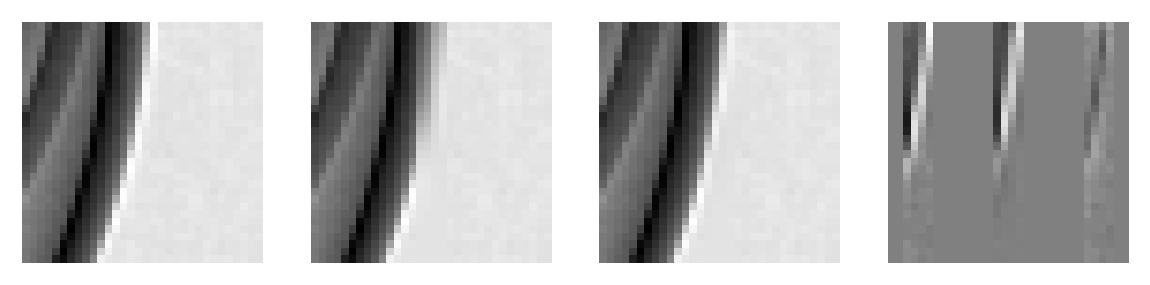

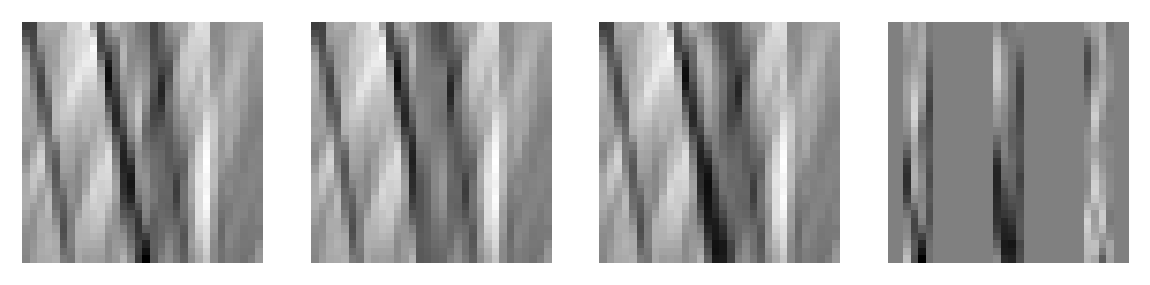

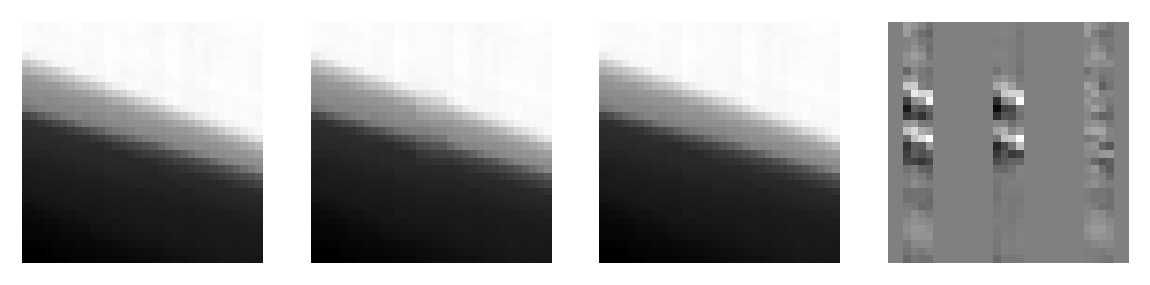

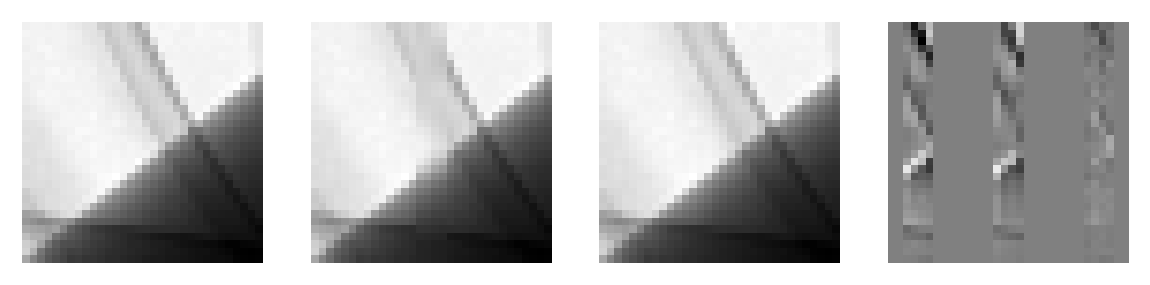

In [13]:
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 15 (14).  Images: 106496. DIS: 0.000e+00, GEN: 1.394e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 1.000e+00  MSE: 1.394e+00  MSEN: 1.165e+00  L1L: 1.871e+00  L1LN: 1.092e+00  SSIM: 1.210e+00  MSSSIM: 2.636e+00 



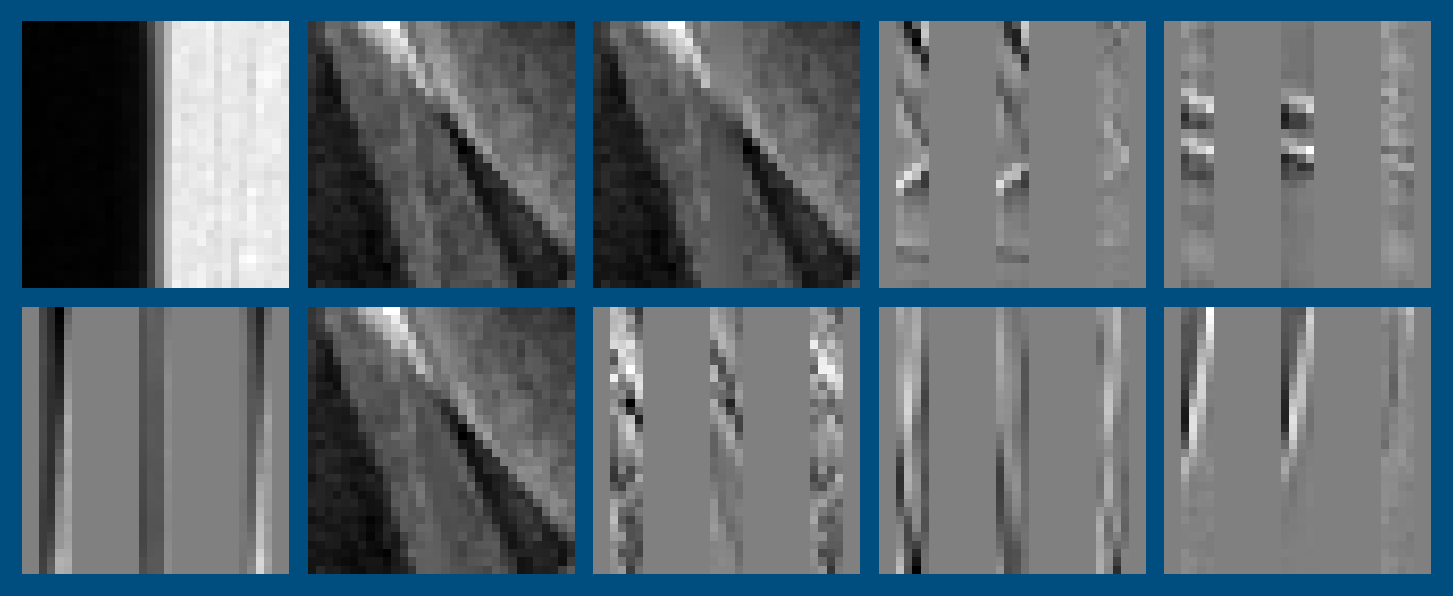

  3%|▎         | 139/4008 [01:22<37:54,  1.70it/s]

In [ ]:


sg.scheduler_G.gamma = 1-0.01
def my_beforeReport(sglocals) :
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.01)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

def my_beforeEachEpoch(sglocals) :

    sg.TCfg.batchSize = min(2**16, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**13))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

try :
    sg.train(savedCheckPoint)
except :

    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# loss MSE raw, BS=2**8, LR=1e-3


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()